## Multiple Items

**Goals** beyond approach for single items:

* manage _coordination_ of ordering
* manage _common constraints_ (budget, space, etc.)
* allow _consolidation_ (shared costs, etc.)
* _conserve management time_

**Techniques**:

* Aggregate SKUs under similar operating policies
    * group via common characteristics or break points
    * group via Power of Two policies
* Manage inventory under common constraints - Exchange Curves
    * for Cycle Stock
    * for Safety Stock

### Group Like Items - Break Points

**Basic Idea**:

Replenish higher value items faster

**Usage**: 

Multiple items with:

* (relatively) stable demand
* *similar* ordering costs, $c_t$
* *similar* holding charges, $h$
* *different* annual demands, $D_i$
* *different* purchase costs, $c_i$

**Approach**:

* let $i$ represent the items under consideration
* pick base time period, $w_0$
    * typically a week
* define set of candidate ordering periods, $w_j$: ($w_1$, $w_2$, etc.)
    * note that the periods must be increasing, s.t. $w_{j-1} < w_j < w_{j+1}$
* find $D_ic_i$ values where $TRC(w_j) = TRC(w_{j+1})$
* group SKUS that fall in common value ($D_ic_i$) buckets

**Rule**:

```
if   D_i * c_i >= 5408 * c_t / (h * w_1 * w_2) then select w_1
elif D_i * c_i >= 5408 * c_t / (h * w_2 * w_3) then select w_2
elif D_i * c_i >= 5408 * c_t / (h * w_3 * w_4) then select w_3
etc ...
```

Note: The value '5408' assumes all costs and demand are defined in annual terms, and the $w_j$ values are _weekly_ increments.  It's calculated as $2 \cdot 52^2$

In [3]:
# TODO: concrete example
# TODO: plot showing how different SKUs fall into groups

### Power of Two Policies

**Motivation**: 

* (from EOQ lessons):
* TRC will be within 6% of optimal when ordering in time intervals of powers of two

**Technique**:

* create table of SKUs
* calculate $T^*$ for each SKU

$$
T^* = \frac{Q^*}{D} \
    = \frac{\sqrt{ \frac{2 c_t D}{c_e} }}{D} \
    = \sqrt{ \frac{ 2 c_t } { D c_e }  }
$$

* calculate $T_{practical}$ for each SKU

$$
p = \Biggl\lceil \frac{\ln{\left( \frac{T^*}{\sqrt{2}} \right) }}{\ln{(2)}} \Biggr\rceil
$$

$$
T_{practical} = 2^{p}
$$

In [4]:
# TODO: concrete example
# TODO: plot showing how different SKUs fall into different groups

### Exchange Curves - Cycle Stock

**Motivation**:

* under a given budget for inventory
* find the best allocation across multiple SKUs
* using cost parameters as policy 'levers'

**Relevant Cost Parameters**:

* holding charge, $h$
* ordering cost, $c_t$

**Exchange Curve**:

* trade-off between TACS and N:
    * total annual cycle stock (TACS)
    * $\sum_{i=1}^n \frac{Q_ic_i}{2}$    
    * number of replenishments (N)
    * $\sum_{i=1}^n \frac{D_i}{Q_i}$
* determine $\frac{c_t}{h}$ that meets budget constraints

Next, put both $N$ and $TACS$ in terms of a ratio of $h$ to $c_t$ by substituting $Q*$ in for $Q$ and simplifying.  After doing that, we arrive at:

$$
TACS = \sqrt{\frac{c_t}{h}}\frac{1}{\sqrt{2}} \sum_{i=1}^n{\sqrt{D_ic_i}}
$$

$$
N = \sqrt{\frac{h}{c_t}}\frac{1}{\sqrt{2}} \sum_{i=1}^n{\sqrt{D_ic_i}}
$$

Finally, generate a range of $\frac{c_t}{h}$ ratios, and corresponding $N$ and $TACS$ values.  These can then be plotted ...


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
%matplotlib inline

In [14]:
hosp_data = pd.read_csv('./W09_L1_V04_hospital_data.csv', index_col=0)
hosp_data.head()

,Sales,Cost
SKU,,
71622,15828,0.14
16396,12708,0.03
38579,5304,0.15
53519,5880,0.00
97176,3936,0.99


In [45]:
from functools import reduce

k = (
    (1 / math.sqrt(2)) *
    (np.sqrt(hosp_data['Sales'] * hosp_data['Cost'])).sum()
)

ratios = (sorted(
    reduce(list.__add__, [
        [i * 10, i * 100, i * 1000] for i in range(1, 10)
    ])
))
ratios.append(10000)
ratios.reverse()

Ns = [math.sqrt(1/ratio) * k for ratio in ratios]
TACSs = [math.sqrt(ratio) * k for ratio in ratios]

In [46]:
exch_df = pd.DataFrame(data={
    "ct/h": ratios, 
    "N": Ns, 
    "TACS": TACSs
})

exch_df.head()

,ct/h,N,TACS
0,10000,13.687904,136879.037045
1,9000,14.428317,129854.856298
2,8000,15.303542,122428.332611
3,7000,16.360174,114521.218766
4,6000,17.671008,106026.046184


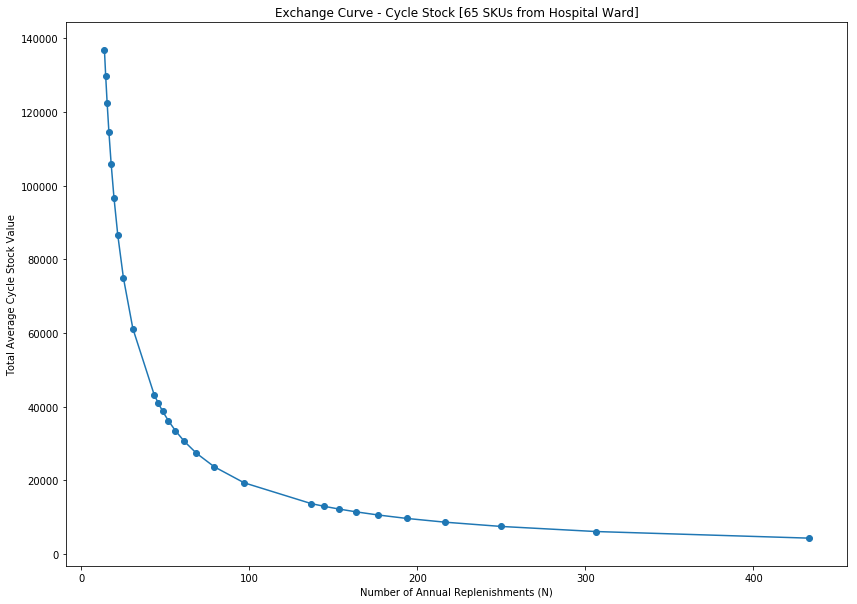

In [49]:
plt.figure(figsize=(14, 10))

plt.plot(exch_df['N'], exch_df['TACS'])
plt.scatter(exch_df['N'], exch_df['TACS'])
plt.xlabel('Number of Annual Replenishments (N)')
plt.ylabel('Total Average Cycle Stock Value')
plt.title('Exchange Curve - Cycle Stock [65 SKUs from Hospital Ward]')
plt.show();

In [ ]:
# TODO: example 1: use curve to determine 

## Exchange Curves - Safety Stock

**Motivation**:

* Have a _safety stock_ budget
* trade-off: cost vs. level of service
* key parameter: $k$ (safety factor)
* estimate aggregate service level for different budgets

**Process**:

1. select target metric
1. start with high value of metric
1. at that level, calculate:
    1. $k_i$ to meet target for each SKU
    1. resulting safety stock for each SKU, and total safety stock (TSS)
    1. other resulting metric of interest for each SKU, and total
1. lower the metric, and go to step 3
1. chart resulting TSS vs inventory metrics


$$
TSS = \sum_{i=1}^n{k_i \sigma_{DL_i} c_i}
$$

Total value of items short (TVIS):

$$
TVIS = \sum_{i=1}^n \left(\frac{D_i}{Q_i} c_i \sigma_{DL_i} G(k_i) \right)
$$

In [2]:
# TODO: table:
# CSL k TVIS TSS
# 0.999 0.99 => 0.50
# TODO: plot curve
# (note): datafile doesn't include sigma values

## Multiple Locations

* How are cycle stock and safety stock levels impacted when they are "pooled" across multiple locations, rather than being managed independently at each location?
* Given $n$ locations, average cycle stock, average safety stock, and average inventory will all be reduced by a factor of $\sqrt{n}$ as a result of pooling the inventory across those locations.
* cycle stock reduces as a result of "pooled" ordering costs, in turn reducing $Q*$ (??)
* safety stock reduces as a result of _Risk Pooling_

## Inventory Management by Segment

* Our focus up to now has been largely on B Items
* (See slide with matrix of interactions against segments)

* Classify handling as:
  * A => Active
      - more time spent managing
      - continuous: (s, S)
      - periodic (R, s, S)
  * B => Automatic
      - continuous: (s, Q)
      - periodic: (R, S)
  * C => Passive
      - less time spent managing
      - periodic: Manual ~ (R,S)

## Inventory Policies for Class A Items

* when is it worth spending more time on these items
    * balance complexity vs other costs
    * balance effort vs savings
* inclusion in Class A largely driven by either $c$ or $D$
    * two types:
    * fast moving but cheap
        - large $D$
        - small $c$
        - => $Q > 1$
        - Normal or Lognormal Distribution
            - as long as $\mu_{DL}$ or $\mu_{DL+R} \ge 10$
    * slow moving but expensive
        - small $D$
        - large $c$
        - => $Q = 1$
        - Poisson Distribution
            - as long as $\mu_{DL}$ or $\mu_{DL+R} \lt 10$

## Fast Moving A Items

* under scenario with Cost per Stock Out Event ($B_1$)
* start with

$$
Q^* = EOQ
$$

and 

$$
k^* = \sqrt{2 \ln{\left(\frac{DB_1}{\sqrt{2 \pi} Q c_e \sigma_{DL}}\right)}}
$$

Then iteratively update both, using:

$$
Q^* = EOQ \sqrt{ 1 + \frac{ B_1 P[x > k] } { c_t }  }
$$

and

$$
k^* = \sqrt{2 \ln{\left(\frac{DB_1}{\sqrt{2 \pi} Q c_e \sigma_{DL}}\right)}}
$$

Until $Q^*$ and $k^*$ converge within some acceptable range.

This will lead to increased cycle stock and decreased safety stock, in turn, reducing likelihood of stockout event.

## Slow Moving Class A Items

* Poisson Distribution
  - probability of events occuring within a time period
  - mean = variance = $\lambda$
  
Example:

Given a desired CSL of 0.95, you'd solve for the first value of $s$ that would produce a Poisson cdf >= 0.95.

In [36]:
from scipy.stats import poisson
import pandas as pd

lmbda = 2.6
demand = list(range(9))
pmf = list(poisson.pmf(x, lmbda) for x in demand)
cdf = list(poisson.cdf(x, lmbda) for x in demand)

df = pd.DataFrame(data={
    'demand': demand,
    'p[x]': pmf,
    'F[x]': cdf
})
print(df)

csl = 0.95
s = (df[df['F[x]'] >= csl]).iloc[0]['demand']
print("\ns: {}".format(s))

   demand      p[x]      F[x]
0       0  0.074274  0.074274
1       1  0.193111  0.267385
2       2  0.251045  0.518430
3       3  0.217572  0.736002
4       4  0.141422  0.877423
5       5  0.073539  0.950963
6       6  0.031867  0.982830
7       7  0.011836  0.994666
8       8  0.003847  0.998513

s: 5.0


What is IFR?

- Loss Function for Discrete Distribution

$$
loss[X_n] =
\begin{cases}
    {mean} - X_1, & \text{if}\ n=1 \\
    loss[X_{n-1}] - (X_n - X_{n-1}) (1 - F[X_{n-1}]), & \text{otherwise}
\end{cases}
$$

In [42]:
loss_x = []
loss_x.append(lmbda - df.loc[0, 'demand'])

for i in range(1, 9):
    loss_x.append(
        loss_x[i - 1] - 
        (df.loc[i, 'demand'] - df.loc[i - 1, 'demand']) *
        (1 - df.loc[i - 1, 'F[x]'])
    )

df['L[x]'] = loss_x
df

,demand,p[x],F[x],L[x]
0,0,0.074274,0.074274,2.600000
1,1,0.193111,0.267385,1.674274
2,2,0.251045,0.518430,0.941658
3,3,0.217572,0.736002,0.460088
4,4,0.141422,0.877423,0.196090
5,5,0.073539,0.950963,0.073513
6,6,0.031867,0.982830,0.024476
7,7,0.011836,0.994666,0.007306
8,8,0.003847,0.998513,0.001972


$IFR = 1 - E[US] / Q$

In [44]:
Q = 6
ifr = 1 - (df.loc[5, 'L[x]'] / Q)
print("IFR: {}".format(ifr))

IFR: 0.9877478051692604


Therefore, at $s=5$, our $E[US] = 0.07$

So $IFR = 1 - (0.07/6) = 98.8%$

What if we want to solve for s given a specific IFR?

In [49]:
# if IFR = 0.80, solve for corresponding E[US]
ifr = 0.80
e_us = Q * (1 - ifr)
print("E[US]: {}".format(e_us))

# use that value to find the s value to satisfy that
s = df[df['L[x]'] <= e_us].iloc[0]['demand']
print("s: {}".format(s))

E[US]: 1.1999999999999997
s: 2.0


## Managing Class C Items

* typically low $cD$ value
* large #, low total value
* diminishing returns on investing in complex policies

**Objective**: minimize management attention

* target simple rules
* explore opportunities for disposing of

### Simple Reorder Rules

* Set common reorder quantities
    * Assume common $c_t$ and $h$ values
    * Find $D_ic_i$ values for ordering frequencies
    * e.g. monthly, quarterly, semi-annual, or annual
    
```
if D_i c_i >= 96 * (c_t / h) then order Monthly
else if D_i c_i >= 16 * (c_t / h) then order Quarterly
else if D_i c_i >= 4 * (c_t / h) then order Semi-Annually
else if D_i c_i >= 4 * (c_t / h) then order Semi-Annually
else order Annually
```


### Disposing of Excess Inventory

* Why does excess occur?
    - SKU portfolio growth
    - poor forecasts - shorter lifecycles
    
* Which items to dispos?
    - look at days-of-supply for each item: $IOH / D$
    - consider getting rid of items that have $DOS > x years$
    
* What actions to take?
    - convert to other uses
    - ship to more desired location
    - mark down price
    - auction